<a href="https://colab.research.google.com/github/the-ml-bull/Hello_World/blob/main/4_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def normalize_data(df, method='price'):
  
  norm_df = df.copy()
  x_fields = ['x_t-4', 'x_t-3', 'x_t-2', 'x_t-1']
  y_fields = ['y_t-0', 'y_t-1', 'y_t-2', 'y_t-3']

  if method == 'price':
    for field in x_fields:
      norm_df[field + '_norm'] = df[field] 
    for field in y_fields:
      norm_df[field + '_norm'] = df[field] 
    
  if method == 'points': 
    for field in x_fields:
      norm_df[field + '_norm'] = (df[field] - df['x_open']) * 100000 
    for field in y_fields:
      norm_df[field + '_norm'] = (df[field] -  df['audusd_open']) * 100000 

  if method == 'percentage':
    for field in x_fields:
      norm_df[field + '_norm'] = (df[field] - df['x_open']) / df[field] * 100
    for field in y_fields:
      norm_df[field + '_norm'] = (df[field] - df['audusd_open']) / df[field] * 100

  if method == 'minmax':
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[x_fields + y_fields])
    norm_field_names = [x + '_norm' for x in x_fields + y_fields]
    norm_df[norm_field_names] = scaled

  if method == 'stddev':
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df[x_fields + y_fields])
    norm_field_names = [x + '_norm' for x in x_fields + y_fields]
    norm_df[norm_field_names] = scaled

  return norm_df 

In [2]:

def get_class_weights(y_train, display=True):
  
  #
  # Create class weights 
  #
  from sklearn.utils.class_weight import compute_class_weight

  num_ones = np.sum(y_train)
  num_zeros = len(y_train) - num_ones 
  
  classes = np.unique(y_train)
  class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
  class_weights = dict(zip(classes, class_weights))

  if display:
    print('In the training set we have 0s {} ({:.2f}%), 1s {} ({:.2f}%)'.format(num_zeros, num_zeros/len(y_train)*100, num_ones, num_ones/len(y_train)*100))
    print('class weights {}'.format(class_weights))

  return class_weights


In [3]:
def get_train_val(df):
  #
  # Create Train and Val datasets 
  # 

  x = df[['x_t-4_norm', 'x_t-3_norm', 'x_t-2_norm', 'x_t-1_norm']] 
  y = df['y']
  y_points = df['y_change_points']

  # Note Fx "follows" (time series) so randomization is NOT a good idea
  # create train and val datasets. 
  no_train_samples = int(len(x) * 0.7)
  x_train = x[4:no_train_samples]
  y_train = y[4:no_train_samples]

  x_val = x[no_train_samples:-3]
  y_val = y[no_train_samples:-3]
  y_val_change_points = y_points[no_train_samples:-3]

  return x_train, y_train, x_val, y_val, y_val_change_points

In [4]:
from sklearn.metrics import log_loss, confusion_matrix, precision_score, recall_score, f1_score

def show_metrics(lr, x, y_true, y_change_points, display=True):
  
  # predict from teh val set meas we have predictions and true values as binaries  
  y_pred = lr.predict(x)

  #basic error types 
  log_loss_error = log_loss(y_true, y_pred)
  score = lr.score(x, y_true)
  
  #
  # Customized metrics  
  #
  tp = np.where((y_pred == 1) & (y_change_points >= 0), 1, 0).sum()
  fp = np.where((y_pred == 1) & (y_change_points < 0), 1, 0).sum()
  tn = np.where((y_pred == 0) & (y_change_points < 0), 1, 0).sum()
  fn = np.where((y_pred == 0) & (y_change_points >= 0), 1, 0).sum()

  precision = 0
  if (tp + fp) > 0:
    precision = tp / (tp + fp)

  recall = 0
  if (tp + fn) > 0:
    recall = tp / (tp + fn)

  f1 = 0
  if (precision + recall) > 0:
    f1 = 2 * precision * recall / (precision + recall)

  # output the errors 
  if display:
    print('Errors Loss: {:.4f}'.format(log_loss_error))
    print('Errors Score: {:.2f}%'.format(score*100))
    print('Errors tp: {} ({:.2f}%)'.format(tp, tp/len(y_val)*100))
    print('Errors fp: {} ({:.2f}%)'.format(fp, fp/len(y_val)*100))
    print('Errors tn: {} ({:.2f}%)'.format(tn, tn/len(y_val)*100))
    print('Errors fn: {} ({:.2f}%)'.format(fn, fn/len(y_val)*100))
    print('Errors Precision: {:.2f}%'.format(precision*100))
    print('Errors Recall: {:.2f}%'.format(recall*100))
    print('Errors F1: {:.2f}'.format(f1*100))

  errors = {
      'loss': log_loss_error,
      'score': score, 
      'tp': tp,
      'fp': fp,
      'tn': tn,
      'fn': fn,
      'precision': precision,
      'recall': recall,
      'f1': f1
      }

  return errors

In [26]:
import random
import matplotlib.pyplot as plt

def chart(norm_df, event_ix_to_plot, norm_method, errors):

  fig, ax = plt.subplots()

  for ix in event_ix_to_plot:

    event = norm_df.iloc[ix]

    x = [-4, -3, -2, -1, 0, 1, 2, 3]
    y = event[['x_t-4_norm', 'x_t-3_norm', 'x_t-2_norm', 'x_t-1_norm', 'y_t-0_norm', 'y_t-1_norm', 'y_t-2_norm', 'y_t-3_norm']]
    
    event_date = '{}'.format(ix) + ' - ' + event['date'].strftime('%Y-%b-%d %H')
    ax.plot(x, y, label=event_date)

  ax.axvline(x = 0, color='black')
  ax.legend(loc='lower right')

  ax.set_title('Method: {}'.format(norm_method))

  textstr = 'loss: {:.2f}\nTP: {}\nFP: {}\nPrecision: {:.2f}%\nRecall: {:.2f}%\nF1: {:.2f}%'.format(
      errors['loss'], errors['tp'], errors['fp'], errors['precision']*100, errors['recall']*100, errors['f1']*100)
  props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
  ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8,
          verticalalignment='top', bbox=props)

  plt.show()

In [6]:
import numpy as np
import pandas as pd 
from datetime import datetime 

def load_data():
  url = 'https://raw.githubusercontent.com/the-ml-bull/Hello_World/main/Fx60.csv'
  dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M')

  df = pd.read_csv(url, parse_dates=['date'], date_parser=dateparse)

  df = df[['date', 'audusd_open', 'audusd_close']].copy()

  # x is the last 4 values so create x for each 
  df['x_open'] = df['audusd_open'].shift(4)
  df['x_t-4'] = df['audusd_close'].shift(4)
  df['x_t-3'] = df['audusd_close'].shift(3)
  df['x_t-2'] = df['audusd_close'].shift(2)
  df['x_t-1'] = df['audusd_close'].shift(1)

  # add all future prices to measurement point 
  df['y_t-0'] = df['audusd_close']
  df['y_t-1'] = df['audusd_close'].shift(-1)
  df['y_t-2'] = df['audusd_close'].shift(-2)
  df['y_t-3'] = df['audusd_close'].shift(-3)

  # y is points 4 periods into the future - the open price now (not close)
  df['y_future'] = df['audusd_close'].shift(-3)
  df['y_change_price'] = df['y_future'] - df['audusd_open']
  df['y_change_points'] = df['y_change_price'] * 100000 
  df['y'] = np.where(df['y_change_points'] >= 200, 1, 0)

  return df 

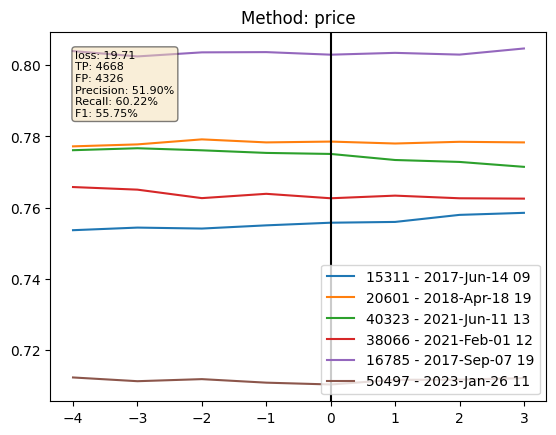

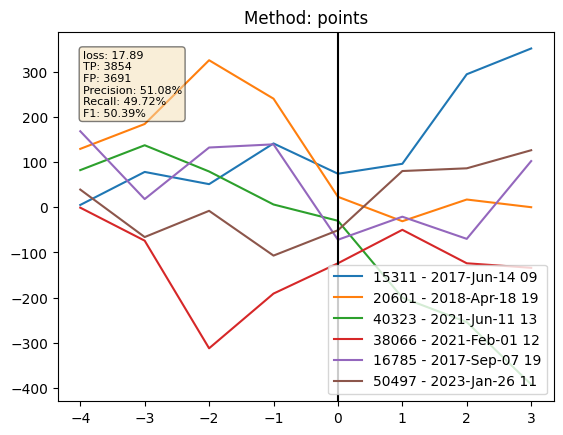

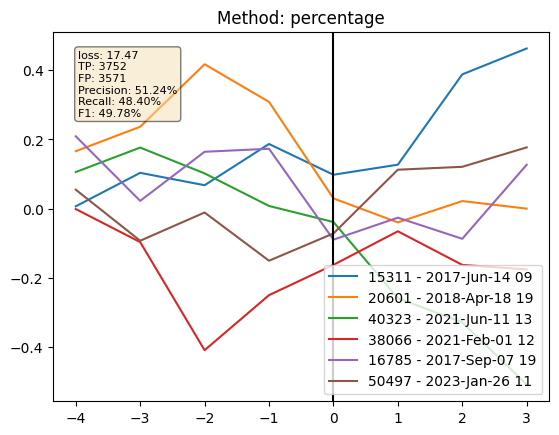

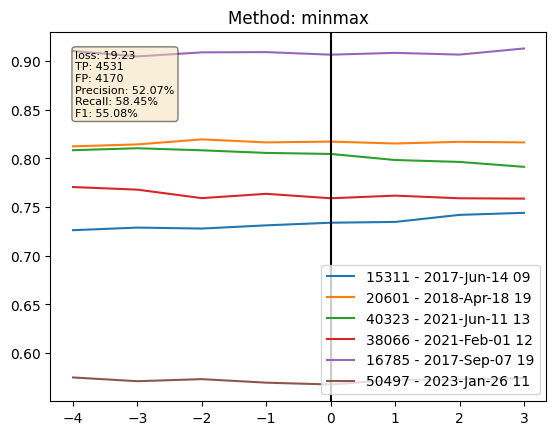

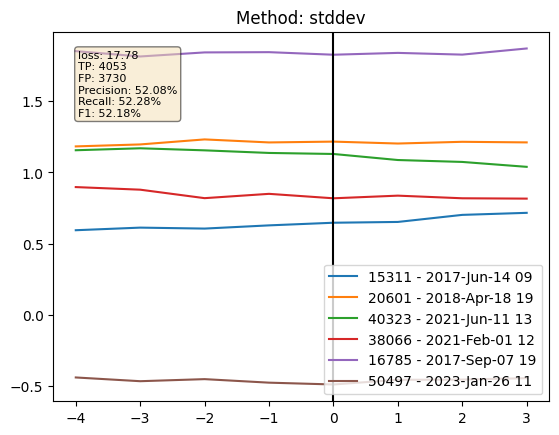

In [27]:
event_ix_to_plot = None 

for norm_method in ['price', 'points', 'percentage', 'minmax', 'stddev']:

  df = load_data()
  norm_df = normalize_data(df, method=norm_method)

  x_train, y_train, x_val, y_val, y_val_change_points = get_train_val(norm_df)

  if event_ix_to_plot is None:
    valid_events = norm_df[norm_df == 1]
    events_to_plot = valid_events.sample(6)
    event_ix_to_plot = events_to_plot.index 

  class_weights = get_class_weights(y_train, display=False)
  
  lr = LogisticRegression(class_weight=class_weights)
  lr.fit(x_train, y_train)

  errors = show_metrics(lr, x_val, y_val, y_val_change_points, display=False)

  chart(norm_df, event_ix_to_plot, norm_method, errors)
